In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import OutfitsDataset
from models import *
from visualizations import plot_loss_curves, plot_roc_curve
from evaluate import compute_metrics

c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create DataLoaders

In [2]:
# Load dataframes
train_img = pd.read_csv('Normal_Outfits_Data/train4siamese.csv')
test_img = pd.read_csv('Normal_Outfits_Data/test4siamese.csv')
train_desc = pd.read_csv('train4clip.csv')
test_desc = pd.read_csv('test4clip.csv')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, saturation=0.5),
    transforms.ToTensor()
])

# Create datasets
train_dataset = OutfitsDataset(train_img, train_desc, transform=train_transform)
test_dataset = OutfitsDataset(test_img, test_desc, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Create Siamese Model

In [20]:
# Define the complete model
class VisualCompatibilityModel(nn.Module):
    def __init__(self, feature_dim=384, num_parts=5, hidden_dim=512):
        super(VisualCompatibilityModel, self).__init__()
        self.feature_extractor = ViTModel()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim * num_parts, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = [self.feature_extractor(part) for part in x]
        combined_features = torch.cat(features, dim=1)
        return self.fc(combined_features)

## Training

In [5]:
# Initialize model, criterion, and optimizer
model = VisualCompatibilityModel()
model = model.cuda() if torch.cuda.is_available() else model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [6]:
# Training and validation loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs = [part.cuda() for part in inputs]
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = [part.cuda() if torch.cuda.is_available() else part for part in inputs]
            labels = labels.cuda() if torch.cuda.is_available() else labels
            
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * labels.size(0)
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

  0%|          | 0/822 [00:00<?, ?it/s]c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
100%|██████████| 822/822 [09:13<00:00,  1.49it/s]


Epoch 1/10, Train Loss: 0.6990, Train Accuracy: 0.5132, Val Loss: 0.6917, Val Accuracy: 0.5151


100%|██████████| 822/822 [09:25<00:00,  1.45it/s]


Epoch 2/10, Train Loss: 0.6780, Train Accuracy: 0.5666, Val Loss: 0.6665, Val Accuracy: 0.5740


100%|██████████| 822/822 [09:31<00:00,  1.44it/s]


Epoch 3/10, Train Loss: 0.6504, Train Accuracy: 0.6117, Val Loss: 0.6481, Val Accuracy: 0.6065


100%|██████████| 822/822 [09:40<00:00,  1.41it/s]


Epoch 4/10, Train Loss: 0.6238, Train Accuracy: 0.6515, Val Loss: 0.6152, Val Accuracy: 0.6599


100%|██████████| 822/822 [09:41<00:00,  1.41it/s]


Epoch 5/10, Train Loss: 0.5991, Train Accuracy: 0.6747, Val Loss: 0.6037, Val Accuracy: 0.6705


100%|██████████| 822/822 [09:32<00:00,  1.44it/s]


Epoch 6/10, Train Loss: 0.5751, Train Accuracy: 0.6966, Val Loss: 0.5917, Val Accuracy: 0.6771


100%|██████████| 822/822 [09:32<00:00,  1.44it/s]


Epoch 7/10, Train Loss: 0.5487, Train Accuracy: 0.7188, Val Loss: 0.5858, Val Accuracy: 0.6914


100%|██████████| 822/822 [09:28<00:00,  1.45it/s]


Epoch 8/10, Train Loss: 0.5277, Train Accuracy: 0.7323, Val Loss: 0.5824, Val Accuracy: 0.6849


100%|██████████| 822/822 [09:24<00:00,  1.46it/s]


Epoch 9/10, Train Loss: 0.5041, Train Accuracy: 0.7495, Val Loss: 0.5922, Val Accuracy: 0.6897


100%|██████████| 822/822 [09:24<00:00,  1.46it/s]


Epoch 10/10, Train Loss: 0.4837, Train Accuracy: 0.7646, Val Loss: 0.5905, Val Accuracy: 0.6832


## Plot Curves

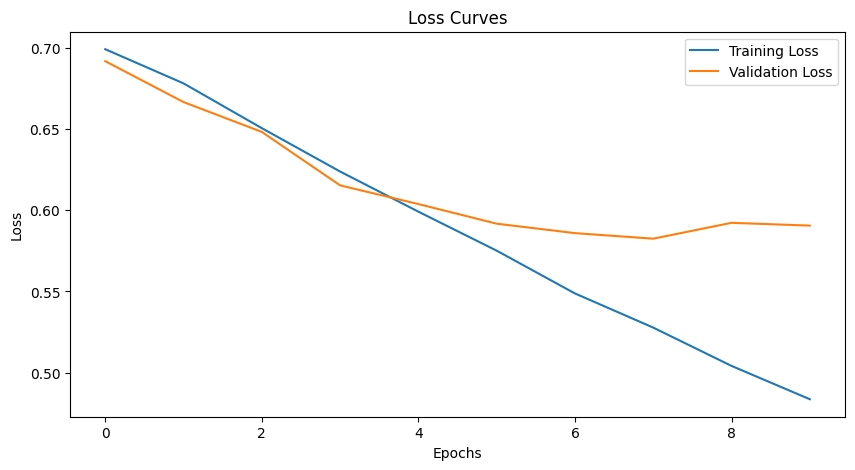

In [8]:
# Plotting the loss curves
plot_loss_curves(train_losses, val_losses)

## Evaluate

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VisualCompatibilityModel().to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for img_inputs, text_inputs, labels in tqdm(test_loader):
        img_inputs = [part.to(device) for part in img_inputs]
        labels = labels.to(device)
        outputs = model(img_inputs)
        preds = outputs.cpu().numpy()  # Assuming a sigmoid activation for binary classification
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

  0%|          | 0/92 [00:00<?, ?it/s]c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
100%|██████████| 92/92 [00:48<00:00,  1.91it/s]


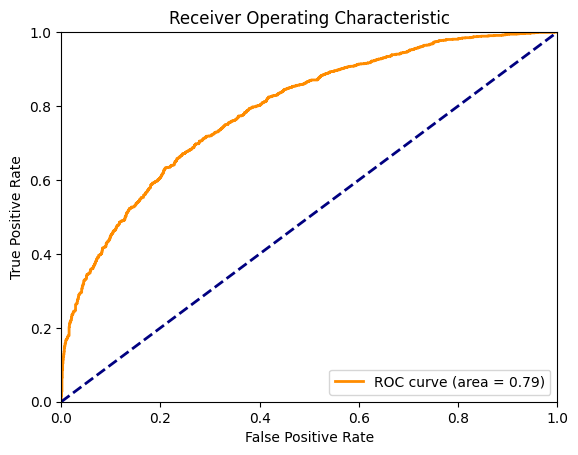

In [24]:
# plot ROC curve
plot_roc_curve(all_labels, all_preds)

In [25]:
metrics = compute_metrics(all_labels, all_preds)
print(metrics)

{'auc': 0.7895421279789829, 'accuracy': 0.7113013698630137, 'precision': 0.7378565921356978, 'recall': 0.6554794520547945, 'f1_score': 0.6942328618063112}
